# Randomly testing things

torch.Size([100])
tensor([[0.7089, 0.6570, 0.6024,  ..., 0.6024, 0.6570, 0.7089],
        [0.6570, 0.6012, 0.5430,  ..., 0.5430, 0.6012, 0.6570],
        [0.6024, 0.5430, 0.4813,  ..., 0.4813, 0.5430, 0.6024],
        ...,
        [0.6024, 0.5430, 0.4813,  ..., 0.4813, 0.5430, 0.6024],
        [0.6570, 0.6012, 0.5430,  ..., 0.5430, 0.6012, 0.6570],
        [0.7089, 0.6570, 0.6024,  ..., 0.6024, 0.6570, 0.7089]])


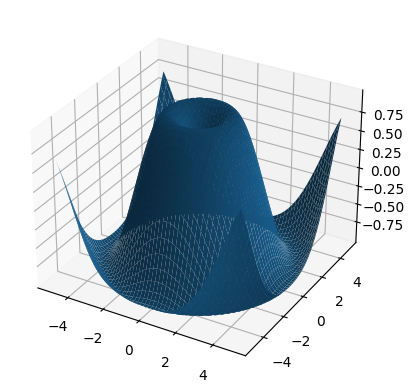

In [ ]:
import torch
import matplotlib.pyplot as plt
xs = torch.linspace(-5,5,steps=100)
ys = torch.linspace(-5,5,steps=100)
# print(xs*xs)
x,y = torch.meshgrid(xs,ys,indexing="xy")
x = x.transpose(-1,-2)
y = y.transpose(-1,-2)
# print(x.transpose())
print(xs.shape)
z=  torch.sin(torch.sqrt(x*x + y*y))
print(z)
ax = plt.axes(projection="3d")
ax.plot_surface(x.numpy(),y.numpy(),z.numpy())
plt.show()

In [ ]:
x = torch.tensor([[2,3,4,5],[1,2,3,4]])
y = torch.cumprod(x,-1)
print(y)
y = torch.roll(y,1,-1)
y[...,0] = 1
print(y)

tensor([[  2,   6,  24, 120],
        [  1,   2,   6,  24]])
tensor([[ 1,  2,  6, 24],
        [ 1,  1,  2,  6]])


# Nano NeRF implementation begins!!!

### generating sphere dataset

In [ ]:
import pygame
from pygame.locals import *

from OpenGL.GL import *
from OpenGL.GLU import *

import numpy as np
from PIL import Image

def create_sphere(num_points):
    vertices = []
    indices = []

    for i in range(num_points):
        for j in range(num_points):
            x = np.sin(np.pi*i/(num_points-1))*np.cos(2*np.pi*j/(num_points-1))
            y = np.sin(np.pi*i/(num_points-1))*np.sin(2*np.pi*j/(num_points-1))
            z = np.cos(np.pi*i/(num_points-1))
            vertices.append((x, y, z))

    for i in range(num_points-1):
        for j in range(num_points-1):
            a = i*num_points + j
            b = i*num_points + j+1
            c = (i+1)*num_points + j+1
            d = (i+1)*num_points + j
            indices.extend([a,b,c,d])
    
    return vertices, indices

def create_camera_matrix(position, target, up):
    f = np.array(target) - np.array(position)
    f = f / np.linalg.norm(f)
    s = np.cross(f, up)
    s = s / np.linalg.norm(s)
    u = np.cross(s, f)
    M = np.identity(4)
    M[:3,:3] = np.column_stack((s,u,-f))
    M[:3,3] = -np.dot(M[:3,:3], np.array(position))
    return M

num_images = 100
image_size = (128, 128)
dataset = np.zeros((num_images, image_size[0], image_size[1], 3), dtype=np.uint8)
transform_matrices = np.zeros((num_images, 4, 4), dtype=np.float32)

vertices, indices = create_sphere(50)

pygame.init()
display = (800, 600)
pygame.display.set_mode(display, DOUBLEBUF|OPENGL)
gluPerspective(45, (display[0]/display[1]), 0.1, 50.0)

for i in range(num_images):

    camera_pos = [0, 0, 4]
    camera_target = [0, 0, 0]

    camera_pos = np.dot(create_camera_matrix([0,0,0], [0,0,1], [0,1,0]), np.array(camera_pos + [1]))[:3]
    camera_target = np.dot(create_camera_matrix([0,0,0], [0,0,1], [0,1,0]), np.array(camera_target + [1]))[:3]
    camera_pos = np.dot(create_camera_matrix([0,0,0], [0,1,0], [0,0,1]), np.array(camera_pos + [1]))[:3]
    camera_target = np.dot(create_camera_matrix([0,0,0], [0,1,0], [0,0,1]), np.array(camera_target + [1]))[:3]
    camera_pos = np.dot(create_camera_matrix([0,0,0], [1,0,0], [0,1,0]), np.array(camera_pos + [1


### some utility functions

In [ ]:
def tor_to_meshgrid(tensor1,tensor2):
  ii , jj = torch.meshgrid(tensor1,tensor2)
  return ii.transpose(-1,-2), jj.transpose(-1,2)

def cunprod(tensor):
  cumprod = torch.cumprod(tensor,-1)
  cumprod = torch.roll(cumprod,1,-1)
  cumprod[...,0] = 1
  return cumprod

### Shooting some rays!! 🔦

In [ ]:
def compute_rays(height,width,focal_length,cam2world):
  x ,y = tor_to_meshgrid(
      torch.arrange(width).to(cam2world),
      torch.arrange(height).to(cam2world)
  )
  directions = torch.stack(
      [(x - width*0.5)/focal_length,
       (y - height*0.5)/focal_length,
       torch.ones_like(x)]
  )
  ray_directions = torch.sum(directions[...,None,:]*cam2world[:3,:3],dim=1)
  ray_origins = cam2world[:3,-1].expand(ray_directions.shape)
  return ray_directions, ray_origins  

In [ ]:
def compute_query_points(ray_directions,ray_origins,near,far,num_samples,random=True):
  depth_values = torch.linspace(near,far,num_samples).to(ray_origins)
  if random:
    shape = list(depth_values.shpae[:,-1]) + [num_samples]
    depth_values = depth_values + torch.rand(shape).to(ray_origins) * (far - near)/num_samples
  query_points = ray_origins[...,None,:] + ray_directions[...,None,:]*depth_values[...,None,:]
  return query_points, depth_values

In [ ]:
def render_volume(rgb,density):
  pass

In [ ]:
def pos_encoding(tensor,num_functions,include_input = True,log_sample=True):
  encoding = [tensor] if include_input else []
  if log_sample:
    frequency_bands = 2.0 ** torch.linspace(
            0.0,
            num_encoding_functions - 1,
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )
  else:
      frequency_bands = torch.linspace(
          2.0 ** 0.0,
          2.0 ** (num_encoding_functions - 1),
          num_encoding_functions,
          dtype=tensor.dtype,
          device=tensor.device,
      )
  for freq in frequency_bands:
      for func in [torch.sin, torch.cos]:
          encoding.append(func(tensor * freq))
  if len(encoding) == 1:
      return encoding[0]
  else:
      return torch.cat(encoding, dim=-1)

# The 🤏 NeRF model

In [ ]:
import torch.nn as nn

In [ ]:
class NeRF(nn.Module):
  def __init__(self,out_channel=128,num_encoding_functions=6):
    super(NeRF,self).__init__()
    self.layer1 = nn.Linear(3 + 3*2*num_encoding_functions,out_channel)
    self.layer2 = nn.Linear(out_channel,out_channel)
    self.layer3 = nn.Linear(out_channel,4)
    self.relu = nn.ReLU()
    
  def forward(self,x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    out = self.layer3(x)
    return out

# Training Loop 🔁

In [ ]:
def train_iter(height,
               width,
               focal_len,
               cam2world,
               near,
               far,
               samples,
               encoding_fun):
  pass